# Upper Confidence Bound method

Txx

In [3]:
import numpy as np

class BanditEnv:
    def __init__(self):
        """10-armed testbed"""
        self.size = 10                                        # 10 arms
        self.means = np.random.randn(self.size)
        
    def step(self, action):
        return np.random.normal(loc=self.means[action])
    
env = BanditEnv()

In [4]:
def decay_epsilon_greedy(env, init_epsilon=1.0, 
                         min_epsilon=0.01, decay_ratio=0.05, 
                         n_episodes=1000):
    Q = np.zeros((env.size), dtype=np.float64)
    N = np.zeros((env.size), dtype=int)
    Qe = np.empty((n_episodes, env.size), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    decay_episodes = int(n_episodes * decay_ratio)
    rem_episodes = n_episodes - decay_episodes
    epsilons = 0.01
    epsilons /= np.logspace(-2, 0, decay_episodes)
    epsilons *= init_epsilon - min_epsilon
    epsilons += min_epsilon
    epsilons = np.pad(epsilons, (0, rem_episodes), 'edge')
    for e in range(n_episodes):
        if np.random.uniform() > epsilons[e]:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))
        reward = env.step(action)    
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        Qe[e] = Q
        returns[e] = reward
    return returns, Qe

In [7]:
def upper_confidence_bound(env, c=2, n_episodes=1000):
    
    Q = np.zeros((env.size), dtype=np.float64)
    N = np.zeros((env.size), dtype=int)
    
    Qe = np.empty((n_episodes, env.size), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)

    for e in range(n_episodes):
        # first select all actions once to avoid division by zero
        if e < len(Q):
            action = e    
        else: 
            # proceed to calculating the confidence bounds
            U = np.sqrt(c * np.log(e)/N)
            # pick the action with the highest value with an 
            # uncertainty bonus: the more uncertain the value of the action, 
            # the higher the bonus
            action = np.argmax(Q + U)

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        
    return returns, Qe

In [8]:
from tqdm import tqdm

returns_epsilon_decay = []
returns_ucb = []

for i in tqdm(range(2000), desc='Running epsilon decay'):
    returns, _ = decay_epsilon_greedy(env=env) 
    returns_epsilon_decay.append(returns); 
    
for i in tqdm(range(2000), desc='Running UCB method'):
    returns, _ = upper_confidence_bound(env=env)
    returns_ucb.append(returns); 

returns_epsilon_decay = np.array(returns_epsilon_decay)
returns_ucb = np.array(returns_ucb)

Running softmax method: 100%|███████████████| 2000/2000 [00:30<00:00, 66.33it/s]


In [10]:
# Average reward
avg_reward_epsilon_decay = np.average(returns_epsilon_decay, axis=0)
avg_reward_ucb = np.average(returns_ucb, axis=0)

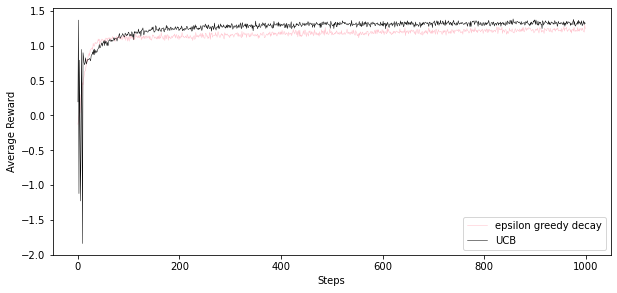

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.plot(avg_reward_epsilon_decay, linewidth=0.5, color='pink',   label='epsilon greedy decay')
plt.plot(avg_reward_ucb, linewidth=0.5, color='black',   label='UCB')
plt.xlabel('Steps');
plt.ylabel('Average Reward')
plt.legend()

plt.show()